In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/DiffusionFT')

In [ ]:
!pip install torch torchvision transformers diffusers accelerate datasets safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
import matplotlib.pyplot as plt

# ────────── CONFIG ──────────
image_dirs  = ["00000", "01000", "02000", "03000", "04000"]
caption_dirs = ["captions0", "captions1", "captions2", "captions3", "captions4"]
#output_dir  = "./lora-finetuned-final"
output_dir  = "./lora-finetuned-armin"
device      = "cuda" if torch.cuda.is_available() else "cpu"
# ────────────────────────────

# Load Stable Diffusion pipeline
base_pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base"
).to(device)
vae, text_encoder, unet, tokenizer = (
    base_pipe.vae,
    base_pipe.text_encoder,
    base_pipe.unet,
    base_pipe.tokenizer,
)

# Reduced-timestep scheduler
base_pipe.scheduler = DDPMScheduler.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="scheduler",
    num_train_timesteps=500,
)

# Apply LoRA
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none",
)
unet = get_peft_model(unet, lora_config).to(device)

# Dataset
class CaptionDataset(Dataset):
    def __init__(self, image_dir, caption_dir, tokenizer, size=256):
        self.image_dir   = Path(image_dir)
        self.caption_dir = Path(caption_dir)
        self.tokenizer   = tokenizer
        self.size        = size
        self.images      = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(self.image_dir / img_name).convert("RGB").resize((self.size, self.size))
        img = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255.0
        with torch.no_grad():
            latents = (
                vae.encode(img.unsqueeze(0).to(device) * 2 - 1)
                .latent_dist.sample()
                * vae.config.scaling_factor
            )

        cap_path = self.caption_dir / f"{Path(img_name).stem}.txt"
        with open(cap_path, "r") as f:
          caption = f.read()
        ids = tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).input_ids[0]

        return latents.squeeze(0).cpu(), ids.cpu()


import copy

def train_lora_model(epochs, lr=1e-5, batch_size=8, max_grad_norm=1.0):
    # Build dataset
    datasets = [
        CaptionDataset(img_dir, cap_dir, tokenizer)
        for img_dir, cap_dir in zip(image_dirs, caption_dirs)
    ]
    dataset = ConcatDataset(datasets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr, weight_decay=1e-2)

    # Exponential Moving Average (EMA) setup
    ema_unet = copy.deepcopy(unet).eval()
    ema_decay = 0.999  # decay factor for EMA

    unet.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (latents, input_ids) in enumerate(dataloader):
            latents, input_ids = latents.to(device), input_ids.to(device)

            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0,
                base_pipe.scheduler.config.num_train_timesteps,
                (latents.shape[0],),
                device=latents.device,
            ).long()

            noisy_lat = base_pipe.scheduler.add_noise(latents, noise, timesteps)
            enc_states = text_encoder(input_ids)[0]

            noise_pred = unet(
                sample=noisy_lat,
                timestep=timesteps,
                encoder_hidden_states=enc_states,
            ).sample

            loss = torch.nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(unet.parameters(), max_grad_norm)

            optimizer.step()

            # Update EMA weights
            with torch.no_grad():
                for p_ema, p in zip(ema_unet.parameters(), unet.parameters()):
                    p_ema.data.mul_(ema_decay).add_(p.data, alpha=1 - ema_decay)

            running_loss += loss.item()

            if i % 5 == 0:
                print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.6f}")

        # Save both unet and EMA version
        unet.save_pretrained(f"{output_dir}/epoch_{epoch}")
        ema_unet.save_pretrained(f"{output_dir}/epoch_{epoch}_ema")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# TRAINING CODE
#######################################################
# DO NOT RUN THIS CELL IF YOU ARE USING THE LOADED MODEL
#######################################################
train_lora_model(epochs=5, lr=2e-5, batch_size=8)

Epoch 0 Step 0 Loss: 0.4411
Epoch 0 Step 5 Loss: 0.4640
Epoch 0 Step 10 Loss: 0.3603
Epoch 0 Step 15 Loss: 0.3655
Epoch 0 Step 20 Loss: 0.3845
Epoch 0 Step 25 Loss: 0.3248
Epoch 0 Step 30 Loss: 0.3459
Epoch 0 Step 35 Loss: 0.2915
Epoch 0 Step 40 Loss: 0.2546
Epoch 0 Step 45 Loss: 0.4248
Epoch 0 Step 50 Loss: 0.3063
Epoch 0 Step 55 Loss: 0.3657
Epoch 0 Step 60 Loss: 0.2937
Epoch 0 Step 65 Loss: 0.2292
Epoch 0 Step 70 Loss: 0.3491
Epoch 0 Step 75 Loss: 0.2156
Epoch 0 Step 80 Loss: 0.3512
Epoch 0 Step 85 Loss: 0.3362
Epoch 0 Step 90 Loss: 0.4287
Epoch 0 Step 95 Loss: 0.3205
Epoch 0 Step 100 Loss: 0.2624
Epoch 0 Step 105 Loss: 0.2872
Epoch 0 Step 110 Loss: 0.3988
Epoch 0 Step 115 Loss: 0.2872
Epoch 0 Step 120 Loss: 0.2728
Epoch 0 Step 125 Loss: 0.2590
Epoch 0 Step 130 Loss: 0.3417
Epoch 0 Step 135 Loss: 0.1880
Epoch 0 Step 140 Loss: 0.3056
Epoch 0 Step 145 Loss: 0.2285
Epoch 0 Step 150 Loss: 0.1801
Epoch 0 Step 155 Loss: 0.3494
Epoch 0 Step 160 Loss: 0.2013
Epoch 0 Step 165 Loss: 0.1989
Ep

In [ ]:
import matplotlib.pyplot as plt


# 1. Generate image from base (non-finetuned) model
def generate_with_base(prompt):
    pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
    image = pipe(prompt).images[0]
    return image


# 3. Generate image from fine-tuned model
def generate_with_finetuned(prompt, pipe):
    pipe.unet = unet_finetuned
    image = pipe(prompt).images[0]
    return image



def plot_images_row(images, titles=None, figsize=(4, 4)):
    """
    Plots N images in a 1 x N row.

    Args:
        images (List[PIL.Image]): List of PIL images to plot.
        titles (List[str], optional): Optional list of titles for each subplot.
        figsize (Tuple[int, int], optional): Size of each subplot (width, height).
    """
    n = len(images)
    plt.figure(figsize=(figsize[0] * n, figsize[1]))

    for i, img in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        if titles and i < len(titles):
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

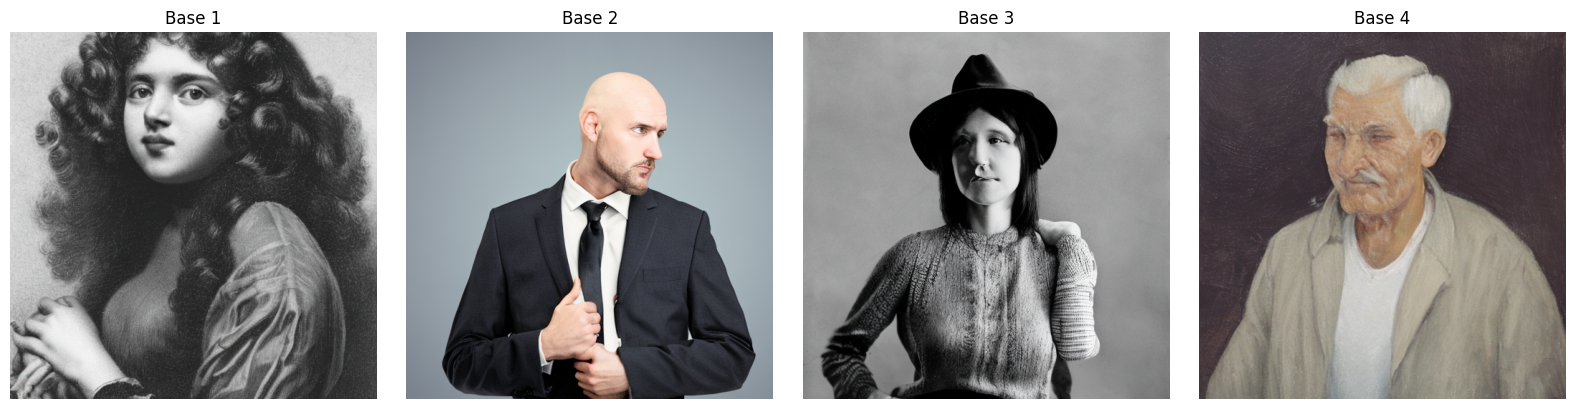

In [ ]:
# Define 3 prompts
prompts = [
    "a young woman with curly hair",
    "a bald man with a tie",
    "a  high fidelity photo of a woman with a hat",
    "an old man with short hair"
]

# Generate images using the base (non-finetuned) model
base_images = [generate_with_base(prompt) for prompt in prompts]
plot_images_row(base_images, titles=[f"Base {i+1}" for i in range(len(prompts))])

In [ ]:
output_dir

'./lora-finetuned-armin'

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

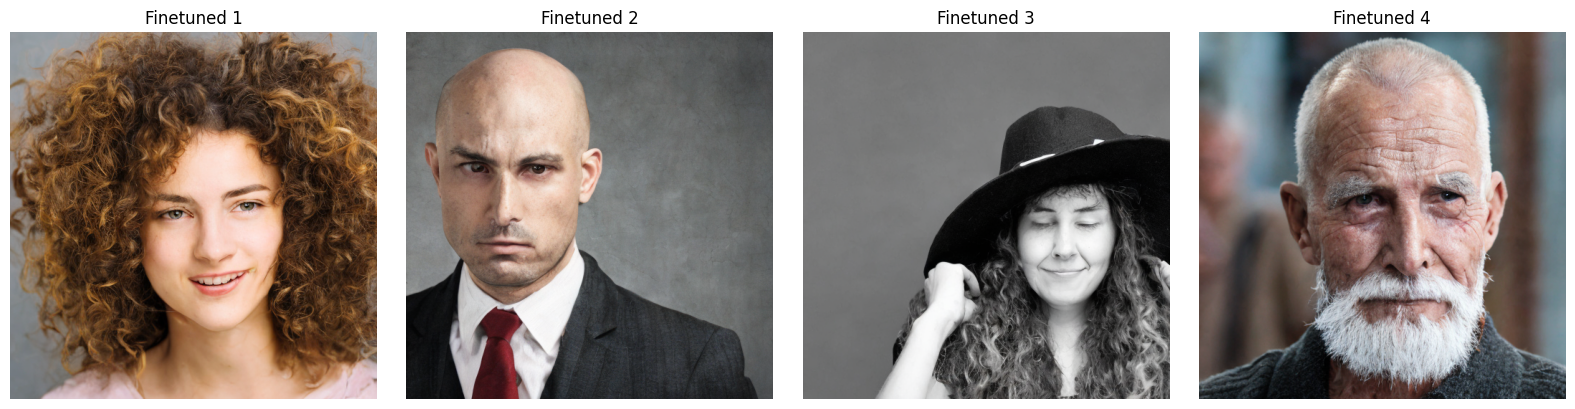

In [ ]:
prompts = [
    "a young woman with curly hair, FFHQ images",
    "a bald man with a tie, FFHQ images",
    "a  high fidelity photo of a woman with a hat, FFHQ images",
    "an old man with short hair, FFHQ images"
]

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
unet_finetuned = get_peft_model(pipe.unet, lora_config)
unet_finetuned.load_adapter(f"{output_dir}/epoch_2_ema", adapter_name="default")

base_images = [generate_with_finetuned(prompt, pipe) for prompt in prompts]
plot_images_row(base_images, titles=[f"Finetuned {i+1}" for i in range(len(prompts))])

In [ ]:
!pip install pytorch-fid

In [ ]:
import os
import random
import shutil
from pathlib import Path
from tqdm import tqdm
from diffusers import StableDiffusionPipeline
from peft import get_peft_model, LoraConfig
from pytorch_fid import fid_score
import torch

# ─── Setup ───
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "lora-finetuned-armin"
real_dir = Path("fid_eval/real")
fake_lora_dir = Path("fid_eval/fake_lora")
fake_base_dir = Path("fid_eval/fake_base")
image_dir = Path("00000")
caption_dir = Path("captions0")

# ─── Reset directories ───
for d in [real_dir, fake_lora_dir, fake_base_dir]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True)

# ─── Select 100 random images ───
all_image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
selected_images = random.sample(all_image_files, 300)
captions = []

for i, image_file in enumerate(selected_images):
    # Save real image
    shutil.copy(image_dir / image_file, real_dir / f"{i}.png")
    # Read caption
    stem = Path(image_file).stem
    with open(caption_dir / f"{stem}.txt", "r") as f:
        caption = f.read().strip()
    captions.append((i, caption))

# ─── Generate with Base SD2.1 ───
print("🔹 Generating base SD2.1 outputs...")
pipe_base = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)

for idx, prompt in tqdm(captions):
    with torch.no_grad():
        image = pipe_base(prompt, guidance_scale=7.5, num_inference_steps=20).images[0]
        image.save(fake_base_dir / f"{idx}.png")

# ─── Generate with LoRA finetuned model ───
print("🔹 Generating LoRA-finetuned outputs...")
pipe_lora = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)

lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none",
)
unet_finetuned = get_peft_model(pipe_lora.unet, lora_config)
unet_finetuned.load_adapter(f"{output_dir}/epoch_2_ema", adapter_name="default")
pipe_lora.unet = unet_finetuned

for idx, prompt in tqdm(captions):
    with torch.no_grad():
        image = pipe_lora(prompt, guidance_scale=7.5, num_inference_steps=45).images[0]
        image.save(fake_lora_dir / f"{idx}.png")



🔹 Generating base SD2.1 outputs...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 1/300 [00:02<13:53,  2.79s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|          | 2/300 [00:04<10:45,  2.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|          | 3/300 [00:06<09:36,  1.94s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▏         | 4/300 [00:07<09:05,  1.84s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▏         | 5/300 [00:09<08:44,  1.78s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▏         | 6/300 [00:11<08:35,  1.75s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▏         | 7/300 [00:12<08:23,  1.72s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 8/300 [00:14<08:15,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 9/300 [00:16<08:12,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 10/300 [00:17<08:08,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|▎         | 11/300 [00:19<08:06,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|▍         | 12/300 [00:21<08:06,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|▍         | 13/300 [00:22<08:04,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▍         | 14/300 [00:24<08:05,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 15/300 [00:26<08:03,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 16/300 [00:28<08:00,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|▌         | 17/300 [00:29<07:55,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|▌         | 18/300 [00:31<07:52,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|▋         | 19/300 [00:33<07:52,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|▋         | 20/300 [00:34<07:52,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|▋         | 21/300 [00:36<07:49,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|▋         | 22/300 [00:38<07:50,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|▊         | 23/300 [00:39<07:48,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|▊         | 24/300 [00:41<07:45,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|▊         | 25/300 [00:43<07:43,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|▊         | 26/300 [00:44<07:39,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|▉         | 27/300 [00:46<07:37,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|▉         | 28/300 [00:48<07:37,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|▉         | 29/300 [00:49<07:34,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 30/300 [00:51<07:31,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 31/300 [00:53<07:32,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|█         | 32/300 [00:54<07:30,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|█         | 33/300 [00:56<07:26,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|█▏        | 34/300 [00:58<07:23,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|█▏        | 35/300 [00:59<07:24,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|█▏        | 36/300 [01:01<07:22,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|█▏        | 37/300 [01:03<07:23,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█▎        | 38/300 [01:05<07:20,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█▎        | 39/300 [01:06<07:19,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█▎        | 40/300 [01:08<07:16,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█▎        | 41/300 [01:10<07:15,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█▍        | 42/300 [01:11<07:14,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█▍        | 43/300 [01:13<07:12,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▍        | 44/300 [01:15<07:11,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▌        | 45/300 [01:16<07:10,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▌        | 46/300 [01:18<07:07,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|█▌        | 47/300 [01:20<07:05,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|█▌        | 48/300 [01:21<07:03,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|█▋        | 49/300 [01:23<07:01,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|█▋        | 50/300 [01:25<07:00,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|█▋        | 51/300 [01:26<06:57,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|█▋        | 52/300 [01:28<06:57,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|█▊        | 53/300 [01:30<06:56,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|█▊        | 54/300 [01:31<06:52,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|█▊        | 55/300 [01:33<06:50,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|█▊        | 56/300 [01:35<06:49,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|█▉        | 57/300 [01:36<06:48,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|█▉        | 58/300 [01:38<06:48,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|█▉        | 59/300 [01:40<06:46,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 60/300 [01:42<06:44,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 61/300 [01:43<06:41,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|██        | 62/300 [01:45<06:43,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|██        | 63/300 [01:47<06:40,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|██▏       | 64/300 [01:48<06:37,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|██▏       | 65/300 [01:50<06:35,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|██▏       | 66/300 [01:52<06:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|██▏       | 67/300 [01:53<06:32,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|██▎       | 68/300 [01:55<06:30,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|██▎       | 69/300 [01:57<06:29,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|██▎       | 70/300 [01:58<06:26,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|██▎       | 71/300 [02:00<06:24,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|██▍       | 72/300 [02:02<06:23,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|██▍       | 73/300 [02:03<06:21,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▍       | 74/300 [02:05<06:18,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 75/300 [02:07<06:16,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 76/300 [02:08<06:14,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██▌       | 77/300 [02:10<06:14,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██▌       | 78/300 [02:12<06:13,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██▋       | 79/300 [02:14<06:12,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██▋       | 80/300 [02:15<06:11,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██▋       | 81/300 [02:17<06:09,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██▋       | 82/300 [02:19<06:06,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|██▊       | 83/300 [02:20<06:05,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|██▊       | 84/300 [02:22<06:03,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|██▊       | 85/300 [02:24<06:02,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|██▊       | 86/300 [02:25<06:01,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|██▉       | 87/300 [02:27<05:58,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|██▉       | 88/300 [02:29<05:56,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|██▉       | 89/300 [02:30<05:53,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 90/300 [02:32<05:51,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 91/300 [02:34<05:48,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|███       | 92/300 [02:35<05:47,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|███       | 93/300 [02:37<05:47,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|███▏      | 94/300 [02:39<05:44,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|███▏      | 95/300 [02:40<05:44,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|███▏      | 96/300 [02:42<05:43,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|███▏      | 97/300 [02:44<05:41,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 98/300 [02:45<05:40,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 99/300 [02:47<05:36,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 100/300 [02:49<05:36,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|███▎      | 101/300 [02:50<05:34,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|███▍      | 102/300 [02:52<05:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|███▍      | 103/300 [02:54<05:30,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▍      | 104/300 [02:55<05:26,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 105/300 [02:57<05:24,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 106/300 [02:59<05:25,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|███▌      | 107/300 [03:01<05:23,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|███▌      | 108/300 [03:02<05:22,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|███▋      | 109/300 [03:04<05:19,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 110/300 [03:06<05:17,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 111/300 [03:07<05:14,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 112/300 [03:09<05:13,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███▊      | 113/300 [03:11<05:11,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███▊      | 114/300 [03:12<05:11,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███▊      | 115/300 [03:14<05:10,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███▊      | 116/300 [03:16<05:07,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███▉      | 117/300 [03:17<05:06,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███▉      | 118/300 [03:19<05:05,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███▉      | 119/300 [03:21<05:03,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 120/300 [03:22<05:02,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 121/300 [03:24<05:00,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████      | 122/300 [03:26<04:57,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████      | 123/300 [03:27<04:57,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████▏     | 124/300 [03:29<04:54,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████▏     | 125/300 [03:31<04:52,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████▏     | 126/300 [03:32<04:51,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████▏     | 127/300 [03:34<04:50,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|████▎     | 128/300 [03:36<04:48,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|████▎     | 129/300 [03:37<04:46,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|████▎     | 130/300 [03:39<04:45,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|████▎     | 131/300 [03:41<04:43,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|████▍     | 132/300 [03:42<04:43,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|████▍     | 133/300 [03:44<04:41,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▍     | 134/300 [03:46<04:40,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 135/300 [03:47<04:37,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 136/300 [03:49<04:36,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|████▌     | 137/300 [03:51<04:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|████▌     | 138/300 [03:52<04:31,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|████▋     | 139/300 [03:54<04:29,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|████▋     | 140/300 [03:56<04:28,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|████▋     | 141/300 [03:57<04:26,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|████▋     | 142/300 [03:59<04:24,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|████▊     | 143/300 [04:01<04:23,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|████▊     | 144/300 [04:03<04:22,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|████▊     | 145/300 [04:04<04:20,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|████▊     | 146/300 [04:06<04:17,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|████▉     | 147/300 [04:08<04:15,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|████▉     | 148/300 [04:09<04:13,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████▉     | 149/300 [04:11<04:12,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 150/300 [04:13<04:10,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 151/300 [04:14<04:09,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|█████     | 152/300 [04:16<04:09,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|█████     | 153/300 [04:18<04:06,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|█████▏    | 154/300 [04:19<04:04,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|█████▏    | 155/300 [04:21<04:03,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|█████▏    | 156/300 [04:23<04:02,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|█████▏    | 157/300 [04:24<04:00,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████▎    | 158/300 [04:26<03:59,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████▎    | 159/300 [04:28<03:57,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████▎    | 160/300 [04:29<03:56,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████▎    | 161/300 [04:31<03:54,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████▍    | 162/300 [04:33<03:52,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████▍    | 163/300 [04:34<03:50,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▍    | 164/300 [04:36<03:49,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 165/300 [04:38<03:47,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 166/300 [04:39<03:44,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|█████▌    | 167/300 [04:41<03:42,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|█████▌    | 168/300 [04:43<03:41,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|█████▋    | 169/300 [04:45<03:40,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 170/300 [04:46<03:38,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 171/300 [04:48<03:37,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 172/300 [04:50<03:34,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|█████▊    | 173/300 [04:51<03:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|█████▊    | 174/300 [04:53<03:31,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|█████▊    | 175/300 [04:55<03:29,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|█████▊    | 176/300 [04:56<03:29,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|█████▉    | 177/300 [04:58<03:27,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|█████▉    | 178/300 [05:00<03:25,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|█████▉    | 179/300 [05:01<03:23,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 180/300 [05:03<03:22,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 181/300 [05:05<03:21,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|██████    | 182/300 [05:06<03:20,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|██████    | 183/300 [05:08<03:18,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|██████▏   | 184/300 [05:10<03:15,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|██████▏   | 185/300 [05:12<03:14,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|██████▏   | 186/300 [05:13<03:13,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|██████▏   | 187/300 [05:15<03:10,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|██████▎   | 188/300 [05:17<03:09,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|██████▎   | 189/300 [05:18<03:07,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|██████▎   | 190/300 [05:20<03:05,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|██████▎   | 191/300 [05:22<03:03,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|██████▍   | 192/300 [05:23<03:01,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|██████▍   | 193/300 [05:25<03:00,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▍   | 194/300 [05:27<02:58,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 195/300 [05:28<02:56,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 196/300 [05:30<02:54,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████▌   | 197/300 [05:32<02:53,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████▌   | 198/300 [05:33<02:51,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████▋   | 199/300 [05:35<02:49,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████▋   | 200/300 [05:37<02:48,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████▋   | 201/300 [05:38<02:46,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████▋   | 202/300 [05:40<02:44,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|██████▊   | 203/300 [05:42<02:41,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|██████▊   | 204/300 [05:43<02:40,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|██████▊   | 205/300 [05:45<02:39,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|██████▊   | 206/300 [05:47<02:38,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|██████▉   | 207/300 [05:49<02:36,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|██████▉   | 208/300 [05:50<02:34,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|██████▉   | 209/300 [05:52<02:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 210/300 [05:54<02:32,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 211/300 [05:55<02:29,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|███████   | 212/300 [05:57<02:27,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|███████   | 213/300 [05:59<02:25,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|███████▏  | 214/300 [06:00<02:24,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|███████▏  | 215/300 [06:02<02:23,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|███████▏  | 216/300 [06:04<02:22,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|███████▏  | 217/300 [06:05<02:20,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|███████▎  | 218/300 [06:07<02:18,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|███████▎  | 219/300 [06:09<02:16,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|███████▎  | 220/300 [06:10<02:14,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|███████▎  | 221/300 [06:12<02:13,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|███████▍  | 222/300 [06:14<02:11,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|███████▍  | 223/300 [06:16<02:10,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▍  | 224/300 [06:17<02:09,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 225/300 [06:19<02:06,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 226/300 [06:21<02:04,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|███████▌  | 227/300 [06:22<02:02,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|███████▌  | 228/300 [06:24<02:00,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|███████▋  | 229/300 [06:26<01:58,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|███████▋  | 230/300 [06:27<01:57,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|███████▋  | 231/300 [06:29<01:55,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|███████▋  | 232/300 [06:31<01:53,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████▊  | 233/300 [06:32<01:52,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████▊  | 234/300 [06:34<01:50,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████▊  | 235/300 [06:36<01:49,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████▊  | 236/300 [06:37<01:48,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████▉  | 237/300 [06:39<01:46,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████▉  | 238/300 [06:41<01:44,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████▉  | 239/300 [06:42<01:42,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 240/300 [06:44<01:40,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 241/300 [06:46<01:38,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████  | 242/300 [06:47<01:37,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████  | 243/300 [06:49<01:35,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████▏ | 244/300 [06:51<01:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████▏ | 245/300 [06:53<01:32,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████▏ | 246/300 [06:54<01:30,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████▏ | 247/300 [06:56<01:28,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|████████▎ | 248/300 [06:57<01:26,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|████████▎ | 249/300 [06:59<01:24,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|████████▎ | 250/300 [07:01<01:23,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|████████▎ | 251/300 [07:02<01:21,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|████████▍ | 252/300 [07:04<01:19,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|████████▍ | 253/300 [07:06<01:18,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▍ | 254/300 [07:07<01:16,  1.66s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 255/300 [07:09<01:15,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 256/300 [07:11<01:13,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|████████▌ | 257/300 [07:13<01:11,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|████████▌ | 258/300 [07:14<01:10,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|████████▋ | 259/300 [07:16<01:09,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|████████▋ | 260/300 [07:18<01:07,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|████████▋ | 261/300 [07:19<01:05,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|████████▋ | 262/300 [07:21<01:04,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|████████▊ | 263/300 [07:23<01:02,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|████████▊ | 264/300 [07:24<01:00,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|████████▊ | 265/300 [07:26<00:58,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|████████▊ | 266/300 [07:28<00:57,  1.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|████████▉ | 267/300 [07:29<00:55,  1.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|████████▉ | 268/300 [07:31<00:53,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████▉ | 269/300 [07:33<00:51,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 270/300 [07:34<00:50,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 271/300 [07:36<00:48,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|█████████ | 272/300 [07:38<00:46,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|█████████ | 273/300 [07:39<00:45,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|█████████▏| 274/300 [07:41<00:43,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|█████████▏| 275/300 [07:43<00:42,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|█████████▏| 276/300 [07:44<00:40,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|█████████▏| 277/300 [07:46<00:38,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████▎| 278/300 [07:48<00:36,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████▎| 279/300 [07:49<00:35,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████▎| 280/300 [07:51<00:33,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████▎| 281/300 [07:53<00:31,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████▍| 282/300 [07:55<00:30,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████▍| 283/300 [07:56<00:28,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████▍| 284/300 [07:58<00:26,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████▌| 285/300 [08:00<00:25,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████▌| 286/300 [08:01<00:23,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|█████████▌| 287/300 [08:03<00:21,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|█████████▌| 288/300 [08:05<00:20,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|█████████▋| 289/300 [08:06<00:18,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|█████████▋| 290/300 [08:08<00:16,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|█████████▋| 291/300 [08:10<00:15,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|█████████▋| 292/300 [08:11<00:13,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|█████████▊| 293/300 [08:13<00:11,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|█████████▊| 294/300 [08:15<00:10,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|█████████▊| 295/300 [08:16<00:08,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|█████████▊| 296/300 [08:18<00:06,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|█████████▉| 297/300 [08:20<00:05,  1.68s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|█████████▉| 298/300 [08:21<00:03,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|█████████▉| 299/300 [08:23<00:01,  1.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 300/300 [08:25<00:00,  1.68s/it]

🔹 Generating LoRA-finetuned outputs...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 1/300 [00:03<18:39,  3.74s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  1%|          | 2/300 [00:07<18:31,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  1%|          | 3/300 [00:11<18:22,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  1%|▏         | 4/300 [00:14<18:20,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 5/300 [00:18<18:13,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 6/300 [00:22<18:12,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 7/300 [00:26<18:08,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  3%|▎         | 8/300 [00:29<18:06,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  3%|▎         | 9/300 [00:33<17:59,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  3%|▎         | 10/300 [00:37<17:55,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  4%|▎         | 11/300 [00:40<17:51,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  4%|▍         | 12/300 [00:44<17:45,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  4%|▍         | 13/300 [00:48<17:43,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  5%|▍         | 14/300 [00:51<17:37,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  5%|▌         | 15/300 [00:55<17:33,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  5%|▌         | 16/300 [00:59<17:26,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  6%|▌         | 17/300 [01:02<17:24,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  6%|▌         | 18/300 [01:06<17:19,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  6%|▋         | 19/300 [01:10<17:16,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  7%|▋         | 20/300 [01:14<17:16,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  7%|▋         | 21/300 [01:17<17:11,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  7%|▋         | 22/300 [01:21<17:08,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  8%|▊         | 23/300 [01:25<17:06,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  8%|▊         | 24/300 [01:28<17:00,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  8%|▊         | 25/300 [01:32<16:58,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  9%|▊         | 26/300 [01:36<16:56,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  9%|▉         | 27/300 [01:40<16:54,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

  9%|▉         | 28/300 [01:43<16:47,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 10%|▉         | 29/300 [01:47<16:43,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 10%|█         | 30/300 [01:51<16:38,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 10%|█         | 31/300 [01:54<16:33,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 11%|█         | 32/300 [01:58<16:27,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 11%|█         | 33/300 [02:02<16:23,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 11%|█▏        | 34/300 [02:05<16:21,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 12%|█▏        | 35/300 [02:09<16:17,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 12%|█▏        | 36/300 [02:13<16:14,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 12%|█▏        | 37/300 [02:16<16:10,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 13%|█▎        | 38/300 [02:20<16:07,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 13%|█▎        | 39/300 [02:24<16:01,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 13%|█▎        | 40/300 [02:27<15:57,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 14%|█▎        | 41/300 [02:31<15:54,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 14%|█▍        | 42/300 [02:35<15:53,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 14%|█▍        | 43/300 [02:39<15:52,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 15%|█▍        | 44/300 [02:42<15:46,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 15%|█▌        | 45/300 [02:46<15:43,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 15%|█▌        | 46/300 [02:50<15:38,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 16%|█▌        | 47/300 [02:53<15:35,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 16%|█▌        | 48/300 [02:57<15:30,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 16%|█▋        | 49/300 [03:01<15:24,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 17%|█▋        | 50/300 [03:04<15:23,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 17%|█▋        | 51/300 [03:08<15:19,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 17%|█▋        | 52/300 [03:12<15:18,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 18%|█▊        | 53/300 [03:16<15:16,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 18%|█▊        | 54/300 [03:19<15:11,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 18%|█▊        | 55/300 [03:23<15:06,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 19%|█▊        | 56/300 [03:27<15:03,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 19%|█▉        | 57/300 [03:30<14:58,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 19%|█▉        | 58/300 [03:34<14:56,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 20%|█▉        | 59/300 [03:38<14:52,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 20%|██        | 60/300 [03:41<14:48,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 20%|██        | 61/300 [03:45<14:45,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 21%|██        | 62/300 [03:49<14:40,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 21%|██        | 63/300 [03:53<14:35,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 21%|██▏       | 64/300 [03:56<14:31,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 22%|██▏       | 65/300 [04:00<14:26,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 22%|██▏       | 66/300 [04:04<14:22,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 22%|██▏       | 67/300 [04:07<14:21,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 23%|██▎       | 68/300 [04:11<14:17,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 23%|██▎       | 69/300 [04:15<14:13,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 23%|██▎       | 70/300 [04:18<14:08,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 24%|██▎       | 71/300 [04:22<14:04,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 24%|██▍       | 72/300 [04:26<13:59,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 24%|██▍       | 73/300 [04:29<13:57,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 25%|██▍       | 74/300 [04:33<13:53,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 25%|██▌       | 75/300 [04:37<13:50,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 25%|██▌       | 76/300 [04:41<13:46,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 26%|██▌       | 77/300 [04:44<13:43,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 26%|██▌       | 78/300 [04:48<13:39,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 26%|██▋       | 79/300 [04:52<13:37,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 27%|██▋       | 80/300 [04:55<13:35,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 27%|██▋       | 81/300 [04:59<13:29,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 27%|██▋       | 82/300 [05:03<13:26,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 28%|██▊       | 83/300 [05:06<13:23,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 28%|██▊       | 84/300 [05:10<13:18,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 28%|██▊       | 85/300 [05:14<13:17,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 29%|██▊       | 86/300 [05:18<13:10,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 29%|██▉       | 87/300 [05:21<13:06,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 29%|██▉       | 88/300 [05:25<13:05,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 30%|██▉       | 89/300 [05:29<12:59,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 30%|███       | 90/300 [05:32<12:55,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 30%|███       | 91/300 [05:36<12:49,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 31%|███       | 92/300 [05:40<12:47,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 31%|███       | 93/300 [05:43<12:44,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 31%|███▏      | 94/300 [05:47<12:39,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 32%|███▏      | 95/300 [05:51<12:35,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 32%|███▏      | 96/300 [05:54<12:31,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 32%|███▏      | 97/300 [05:58<12:28,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 33%|███▎      | 98/300 [06:02<12:27,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 33%|███▎      | 99/300 [06:06<12:25,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 33%|███▎      | 100/300 [06:09<12:20,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 34%|███▎      | 101/300 [06:13<12:16,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 34%|███▍      | 102/300 [06:17<12:13,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 34%|███▍      | 103/300 [06:20<12:08,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 35%|███▍      | 104/300 [06:24<12:04,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 35%|███▌      | 105/300 [06:28<12:01,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 35%|███▌      | 106/300 [06:31<11:58,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 36%|███▌      | 107/300 [06:35<11:53,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 36%|███▌      | 108/300 [06:39<11:49,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 36%|███▋      | 109/300 [06:42<11:44,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 37%|███▋      | 110/300 [06:46<11:41,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 37%|███▋      | 111/300 [06:50<11:38,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 37%|███▋      | 112/300 [06:54<11:34,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 38%|███▊      | 113/300 [06:57<11:30,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 38%|███▊      | 114/300 [07:01<11:23,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 38%|███▊      | 115/300 [07:05<11:21,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 39%|███▊      | 116/300 [07:08<11:17,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 39%|███▉      | 117/300 [07:12<11:14,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 39%|███▉      | 118/300 [07:16<11:12,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 40%|███▉      | 119/300 [07:19<11:08,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 40%|████      | 120/300 [07:23<11:04,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 40%|████      | 121/300 [07:27<11:00,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 41%|████      | 122/300 [07:30<10:55,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 41%|████      | 123/300 [07:34<10:53,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 41%|████▏     | 124/300 [07:38<10:50,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 42%|████▏     | 125/300 [07:42<10:48,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 42%|████▏     | 126/300 [07:45<10:42,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 42%|████▏     | 127/300 [07:49<10:39,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 43%|████▎     | 128/300 [07:53<10:36,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 43%|████▎     | 129/300 [07:56<10:32,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 43%|████▎     | 130/300 [08:00<10:29,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 44%|████▎     | 131/300 [08:04<10:25,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 44%|████▍     | 132/300 [08:07<10:22,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 44%|████▍     | 133/300 [08:11<10:17,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 45%|████▍     | 134/300 [08:15<10:15,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 45%|████▌     | 135/300 [08:19<10:09,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 45%|████▌     | 136/300 [08:22<10:06,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 46%|████▌     | 137/300 [08:26<10:02,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 46%|████▌     | 138/300 [08:30<09:58,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 46%|████▋     | 139/300 [08:33<09:53,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 47%|████▋     | 140/300 [08:37<09:50,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 47%|████▋     | 141/300 [08:41<09:47,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 47%|████▋     | 142/300 [08:44<09:44,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 48%|████▊     | 143/300 [08:48<09:41,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 48%|████▊     | 144/300 [08:52<09:38,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 48%|████▊     | 145/300 [08:56<09:34,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 49%|████▊     | 146/300 [08:59<09:30,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 49%|████▉     | 147/300 [09:03<09:26,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 49%|████▉     | 148/300 [09:07<09:21,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 50%|████▉     | 149/300 [09:10<09:17,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 50%|█████     | 150/300 [09:14<09:13,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 50%|█████     | 151/300 [09:18<09:11,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 51%|█████     | 152/300 [09:21<09:08,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 51%|█████     | 153/300 [09:25<09:05,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 51%|█████▏    | 154/300 [09:29<09:02,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 52%|█████▏    | 155/300 [09:33<08:59,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 52%|█████▏    | 156/300 [09:36<08:57,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 52%|█████▏    | 157/300 [09:40<08:53,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 53%|█████▎    | 158/300 [09:44<08:49,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 53%|█████▎    | 159/300 [09:48<08:45,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 53%|█████▎    | 160/300 [09:51<08:41,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 54%|█████▎    | 161/300 [09:55<08:37,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 54%|█████▍    | 162/300 [09:59<08:32,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 54%|█████▍    | 163/300 [10:02<08:28,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 55%|█████▍    | 164/300 [10:06<08:27,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 55%|█████▌    | 165/300 [10:10<08:22,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 55%|█████▌    | 166/300 [10:14<08:18,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 56%|█████▌    | 167/300 [10:17<08:14,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 56%|█████▌    | 168/300 [10:21<08:10,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 56%|█████▋    | 169/300 [10:25<08:06,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 57%|█████▋    | 170/300 [10:28<08:03,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 57%|█████▋    | 171/300 [10:32<07:59,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 57%|█████▋    | 172/300 [10:36<07:53,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 58%|█████▊    | 173/300 [10:40<07:49,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 58%|█████▊    | 174/300 [10:43<07:45,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 58%|█████▊    | 175/300 [10:47<07:42,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 59%|█████▊    | 176/300 [10:51<07:39,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 59%|█████▉    | 177/300 [10:54<07:36,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 59%|█████▉    | 178/300 [10:58<07:32,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 60%|█████▉    | 179/300 [11:02<07:28,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 60%|██████    | 180/300 [11:05<07:24,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 60%|██████    | 181/300 [11:09<07:20,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 61%|██████    | 182/300 [11:13<07:15,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 61%|██████    | 183/300 [11:17<07:11,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 61%|██████▏   | 184/300 [11:20<07:07,  3.68s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 62%|██████▏   | 185/300 [11:24<07:04,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 62%|██████▏   | 186/300 [11:28<07:00,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 62%|██████▏   | 187/300 [11:31<06:57,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 63%|██████▎   | 188/300 [11:35<06:53,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 63%|██████▎   | 189/300 [11:39<06:50,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 63%|██████▎   | 190/300 [11:42<06:47,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 64%|██████▎   | 191/300 [11:46<06:44,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 64%|██████▍   | 192/300 [11:50<06:41,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 64%|██████▍   | 193/300 [11:54<06:36,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 65%|██████▍   | 194/300 [11:57<06:32,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 65%|██████▌   | 195/300 [12:01<06:28,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 65%|██████▌   | 196/300 [12:05<06:25,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 66%|██████▌   | 197/300 [12:08<06:21,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 66%|██████▌   | 198/300 [12:12<06:17,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 66%|██████▋   | 199/300 [12:16<06:13,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 67%|██████▋   | 200/300 [12:19<06:10,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 67%|██████▋   | 201/300 [12:23<06:07,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 67%|██████▋   | 202/300 [12:27<06:03,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 68%|██████▊   | 203/300 [12:31<05:58,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 68%|██████▊   | 204/300 [12:34<05:55,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 68%|██████▊   | 205/300 [12:38<05:51,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 69%|██████▊   | 206/300 [12:42<05:48,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 69%|██████▉   | 207/300 [12:45<05:44,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 69%|██████▉   | 208/300 [12:49<05:39,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 70%|██████▉   | 209/300 [12:53<05:35,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 70%|███████   | 210/300 [12:56<05:32,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 70%|███████   | 211/300 [13:00<05:29,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 71%|███████   | 212/300 [13:04<05:25,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 71%|███████   | 213/300 [13:08<05:21,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 71%|███████▏  | 214/300 [13:11<05:18,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 72%|███████▏  | 215/300 [13:15<05:14,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 72%|███████▏  | 216/300 [13:19<05:11,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 72%|███████▏  | 217/300 [13:22<05:08,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 73%|███████▎  | 218/300 [13:26<05:03,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 73%|███████▎  | 219/300 [13:30<04:59,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 73%|███████▎  | 220/300 [13:34<04:56,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 74%|███████▎  | 221/300 [13:37<04:52,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 74%|███████▍  | 222/300 [13:41<04:49,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 74%|███████▍  | 223/300 [13:45<04:45,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 75%|███████▍  | 224/300 [13:48<04:42,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 75%|███████▌  | 225/300 [13:52<04:37,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 75%|███████▌  | 226/300 [13:56<04:34,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 76%|███████▌  | 227/300 [13:59<04:29,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 76%|███████▌  | 228/300 [14:03<04:25,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 76%|███████▋  | 229/300 [14:07<04:22,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 77%|███████▋  | 230/300 [14:10<04:18,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 77%|███████▋  | 231/300 [14:14<04:15,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 77%|███████▋  | 232/300 [14:18<04:11,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 78%|███████▊  | 233/300 [14:22<04:08,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 78%|███████▊  | 234/300 [14:25<04:04,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 78%|███████▊  | 235/300 [14:29<04:00,  3.69s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 79%|███████▊  | 236/300 [14:33<03:56,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 79%|███████▉  | 237/300 [14:36<03:53,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 79%|███████▉  | 238/300 [14:40<03:49,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 80%|███████▉  | 239/300 [14:44<03:45,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 80%|████████  | 240/300 [14:48<03:42,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 80%|████████  | 241/300 [14:51<03:39,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 81%|████████  | 242/300 [14:55<03:41,  3.82s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 81%|████████  | 243/300 [14:59<03:35,  3.79s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 81%|████████▏ | 244/300 [15:03<03:31,  3.77s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 82%|████████▏ | 245/300 [15:06<03:26,  3.75s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 82%|████████▏ | 246/300 [15:10<03:21,  3.74s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 82%|████████▏ | 247/300 [15:14<03:17,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 83%|████████▎ | 248/300 [15:18<03:13,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 83%|████████▎ | 249/300 [15:21<03:09,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 83%|████████▎ | 250/300 [15:25<03:05,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 84%|████████▎ | 251/300 [15:29<03:01,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 84%|████████▍ | 252/300 [15:33<02:58,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 84%|████████▍ | 253/300 [15:36<02:54,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 85%|████████▍ | 254/300 [15:40<02:50,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 85%|████████▌ | 255/300 [15:44<02:46,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 85%|████████▌ | 256/300 [15:47<02:42,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 86%|████████▌ | 257/300 [15:51<02:39,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 86%|████████▌ | 258/300 [15:55<02:35,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 86%|████████▋ | 259/300 [15:58<02:32,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 87%|████████▋ | 260/300 [16:02<02:28,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 87%|████████▋ | 261/300 [16:06<02:24,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 87%|████████▋ | 262/300 [16:09<02:20,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 88%|████████▊ | 263/300 [16:13<02:16,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 88%|████████▊ | 264/300 [16:17<02:13,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 88%|████████▊ | 265/300 [16:21<02:09,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 89%|████████▊ | 266/300 [16:24<02:06,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 89%|████████▉ | 267/300 [16:28<02:02,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 89%|████████▉ | 268/300 [16:32<01:58,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 90%|████████▉ | 269/300 [16:35<01:55,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 90%|█████████ | 270/300 [16:39<01:51,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 90%|█████████ | 271/300 [16:43<01:47,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 91%|█████████ | 272/300 [16:47<01:43,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 91%|█████████ | 273/300 [16:50<01:40,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 91%|█████████▏| 274/300 [16:54<01:36,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 92%|█████████▏| 275/300 [16:58<01:32,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 92%|█████████▏| 276/300 [17:01<01:29,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 92%|█████████▏| 277/300 [17:05<01:25,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 93%|█████████▎| 278/300 [17:09<01:21,  3.73s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 93%|█████████▎| 279/300 [17:13<01:18,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 93%|█████████▎| 280/300 [17:16<01:14,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 94%|█████████▎| 281/300 [17:20<01:10,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 94%|█████████▍| 282/300 [17:24<01:06,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 94%|█████████▍| 283/300 [17:27<01:03,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 95%|█████████▍| 284/300 [17:31<00:59,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 95%|█████████▌| 285/300 [17:35<00:55,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 95%|█████████▌| 286/300 [17:39<00:51,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 96%|█████████▌| 287/300 [17:42<00:48,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 96%|█████████▌| 288/300 [17:46<00:44,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 96%|█████████▋| 289/300 [17:50<00:40,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 97%|█████████▋| 290/300 [17:53<00:37,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 97%|█████████▋| 291/300 [17:57<00:33,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 97%|█████████▋| 292/300 [18:01<00:29,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 98%|█████████▊| 293/300 [18:05<00:25,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 98%|█████████▊| 294/300 [18:08<00:22,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 98%|█████████▊| 295/300 [18:12<00:18,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 99%|█████████▊| 296/300 [18:16<00:14,  3.71s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 99%|█████████▉| 297/300 [18:19<00:11,  3.72s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

 99%|█████████▉| 298/300 [18:23<00:07,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

100%|█████████▉| 299/300 [18:27<00:03,  3.70s/it]

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 300/300 [18:31<00:00,  3.70s/it]


In [ ]:
# ─── Compute FID Scores ───
print("\n📊 Calculating FID scores...\n")

fid_real_vs_lora = fid_score.calculate_fid_given_paths(
    [str(real_dir), str(fake_lora_dir)],
    batch_size=32, device=device, dims=2048,
)

fid_real_vs_base = fid_score.calculate_fid_given_paths(
    [str(real_dir), str(fake_base_dir)],
    batch_size=32, device=device, dims=2048,
)

fid_base_vs_lora = fid_score.calculate_fid_given_paths(
    [str(fake_base_dir), str(fake_lora_dir)],
    batch_size=32, device=device, dims=2048,
)

fid_real_vs_real = fid_score.calculate_fid_given_paths(   # <- no overwrite
    [str(real_dir), str(real_dir)],
    batch_size=32, device=device, dims=2048,
)

# ─── Report ───
print(f"✅ FID (Real ↔ LoRA)  : {fid_real_vs_lora:.4f}")
print(f"✅ FID (Real ↔ Base)  : {fid_real_vs_base:.4f}")
print(f"✅ FID (Base ↔ LoRA)  : {fid_base_vs_lora:.4f}")
print(f"✅ FID (Real ↔ Real)  : {fid_real_vs_real:.4f}")  # should be ~0


📊 Calculating FID scores...



Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 298MB/s]
100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


✅ FID (Real ↔ LoRA)  : 118.5297
✅ FID (Real ↔ Base)  : 131.1825
✅ FID (Base ↔ LoRA)  : 83.6284
✅ FID (Real ↔ Real)  : -0.0001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 207MB/s] 
Extracting from fake_lora: 100%|██████████| 100/100 [00:03<00:00, 30.15it/s]


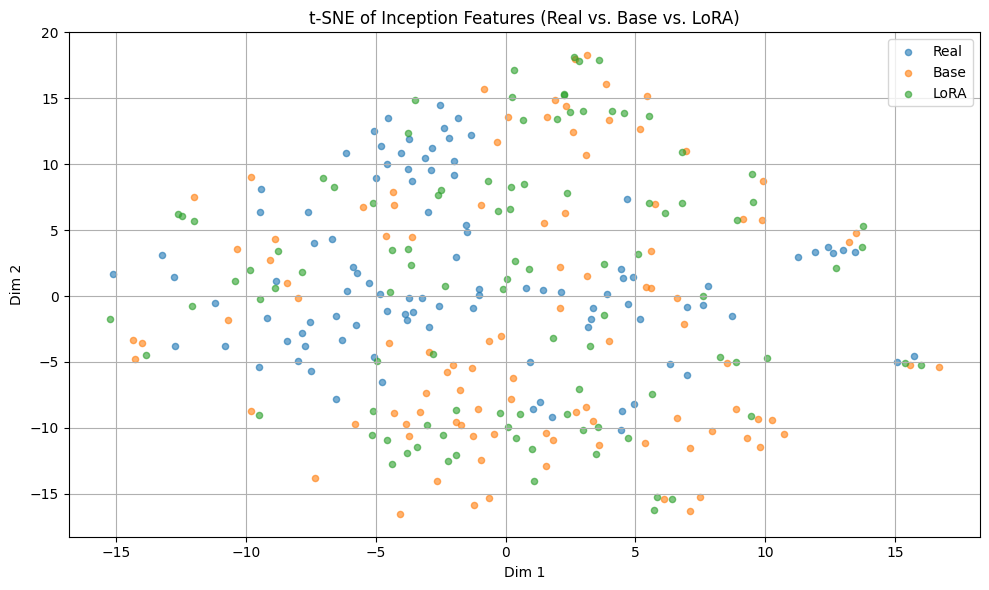

In [ ]:
# Re-run setup and imports after kernel reset

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
from torchvision import transforms
from torchvision.models import inception_v3
import torch

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained InceptionV3 model for feature extraction
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.fc = torch.nn.Identity()
inception.eval()

# Directories
real_dir = Path("fid_eval/real")
base_dir = Path("fid_eval/fake_base")
lora_dir = Path("fid_eval/fake_lora")

# Preprocessing for InceptionV3
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Extract features
def extract_features(image_dir, max_images=100):
    features = []
    image_paths = sorted(list(image_dir.glob("*.png")))[:max_images]
    for img_path in tqdm(image_paths, desc=f"Extracting from {image_dir.name}"):
        img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = inception(img_tensor).cpu().numpy()
        features.append(feat)
    return np.concatenate(features, axis=0)

real_feats = extract_features(real_dir)
base_feats = extract_features(base_dir)
lora_feats = extract_features(lora_dir)

# Run t-SNE
X = np.concatenate([real_feats, base_feats, lora_feats], axis=0)
labels = (["Real"] * len(real_feats) +
          ["Base"] * len(base_feats) +
          ["LoRA"] * len(lora_feats))

tsne = TSNE(n_components=2, perplexity=30, init="random", random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
for label in ["Real", "Base", "LoRA"]:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], label=label, alpha=0.6, s=20)
plt.legend()
plt.title("t-SNE of Inception Features (Real vs. Base vs. LoRA)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting from fake_lora: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


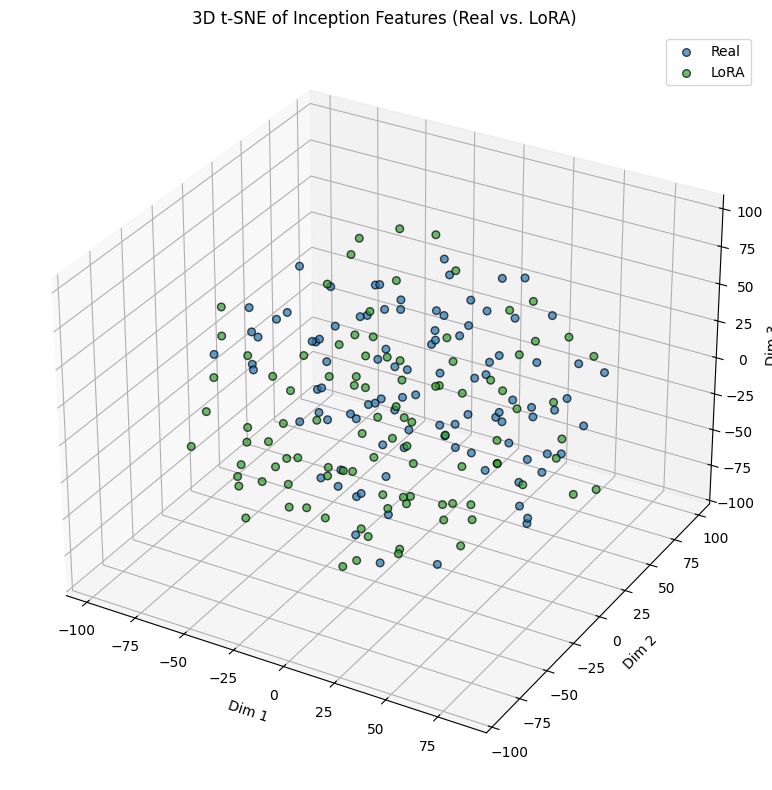

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
from torchvision.models import inception_v3
import torch


# Load pretrained InceptionV3 model
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.fc = torch.nn.Identity()
inception.eval()

# Set paths
real_dir = Path("fid_eval/real")
lora_dir = Path("fid_eval/fake_lora")

# Preprocessing for Inception
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Feature extraction
def extract_features(image_dir, max_images=100):
    features = []
    image_paths = sorted(list(image_dir.glob("*.png")))[:max_images]
    for img_path in tqdm(image_paths, desc=f"Extracting from {image_dir.name}"):
        img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = inception(img_tensor).cpu().numpy()
        features.append(feat)
    return np.concatenate(features, axis=0)

# Extract features
real_feats = extract_features(real_dir)
lora_feats = extract_features(lora_dir)

# Combine and label
X = np.concatenate([real_feats, lora_feats], axis=0)
labels = (["Real"] * len(real_feats) +
          ["LoRA"] * len(lora_feats))

# Run 3D t-SNE
tsne = TSNE(n_components=3, perplexity=30, init="random", random_state=42)
X_tsne_3d = tsne.fit_transform(X)

# Plot 3D scatter
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = {"Real": "tab:blue", "LoRA": "tab:green"}

for label in ["Real", "LoRA"]:
    idxs = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(
        X_tsne_3d[idxs, 0], X_tsne_3d[idxs, 1], X_tsne_3d[idxs, 2],
        label=label, color=colors[label], edgecolor='black', s=30, alpha=0.7
    )

ax.set_title("3D t-SNE of Inception Features (Real vs. LoRA)")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.legend()
plt.tight_layout()
plt.show()
